### The Business Problem
The objective of this study is to study neighborhoods in New York City to find the best neighborhood to open a pharmaceutical/Medicine manufacturing company. The company should have a wide variety of employees in terms of cultural diversity to promote a variety of perspectives, increased creativity, global impact, reduced fear, improved performance and boost the brand’s reputation.

In [1]:
pip install bs4

     |████████████████████████████████| 112kB 22.7MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install geopy

     |████████████████████████████████| 112kB 6.2MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Libraries imported.')

Libraries imported.


##### Obtaining Neighborhoods using FourSquare API & New York City data that contains list of Boroughs, Neighbourhoods along with their latitude and longitude.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

##### A function to interact with FourSquare API and get top 500 venues within a radius of 2000 metres for a given latitude and longitude. This will ensure that all pharmacies are extracted.

In [104]:
def get_venues(lat,lng):
    
    #set variables
    radius=2000
    LIMIT=500
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

 ##### Defining a function to get venue details such as count , rating , tip counts for a given pharmacy id. to be used for ranking.

In [103]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

##### Defining a funtion to get the New York city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [16]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

Data Frame containing the data of New York

In [17]:
# Getting new york data
new_york_data=get_new_york_data()

In [18]:
new_york_data.tail()

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [19]:
new_york_data.shape

(306, 4)

There 306 neighborhoods in New York City. 

I am now groping the Neighborhoods in New York City By Borough

In [20]:
dat=new_york_data.groupby('Borough')['Neighborhood'].count()

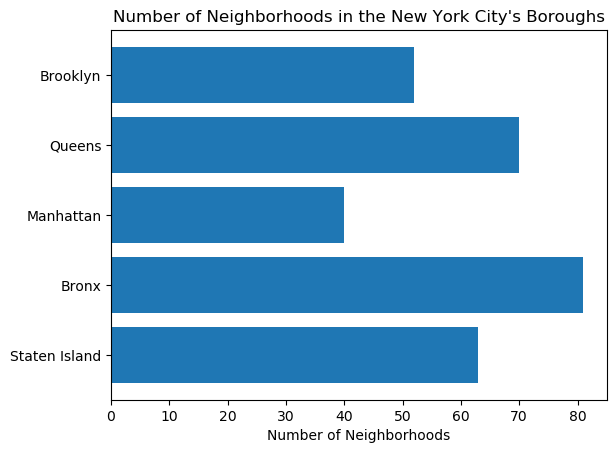

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(dat))
boroughs = ('Brooklyn', 'Queens', 'Manhattan', 'Bronx', 'Staten Island')

ax.barh(y_pos, dat)
ax.set_yticks(y_pos)
ax.set_yticklabels(boroughs)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Number of Neighborhoods")
ax.set_title("Number of Neighborhoods in the New York City's Boroughs")

plt.show()

##### Based on the dataset, there are a total of 306 different Neighborhoods in New York to select Pharmacies from.

In [22]:
new_york_data.tail(2)

,Borough,Neighborhood,Latitude,Longitude
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


The Following code extracts all Pharmacies in the New City's Neighborhoods

In [23]:
# Preparing neighborhood list that contains Pharmacies
column_names=['Borough', 'Neighborhood', 'ID','Name']
pharmacy_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    pharmacies=venues[venues['Category']=='Pharmacy']   
    #print('(',count,'/',len(new_york_data),')','Pharmacies in '+Neighborhood+', '+Borough+':'+str(len(pharmacies)))
    for Pharmacy_detail in pharmacies.values.tolist():
        id, name , category=Pharmacy_detail
        pharmacy_ny = pharmacy_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

The following data frame contains all Pharmacies, their borough, Neighborhood, ID and Pharmacy name

In [24]:
pharmacy_ny.tail()

,Borough,Neighborhood,ID,Name
500,Queens,Bayswater,50058548e4b07c19de39effd,Vista Pharmacy & Surgical
501,Staten Island,Fox Hills,4b2ea393f964a5200ae424e3,CVS pharmacy
502,Staten Island,Fox Hills,4ce97b54595cb1f723e8ce14,Rite Aid
503,Staten Island,Fox Hills,4df38b0522718759f82017a1,Millers pharmacy
504,Staten Island,Fox Hills,4c4722f71ddec9289e639c32,"Classic Pharmacy, Inc."


In [25]:
pharmacy_ny.shape  

(505, 4)

The data frame says that there are 498 Pharmacies in New York City, but on careful analysis of unique ID's it was found that there are duplicates ID's pulled from four square API, these duplicates are removed by the following line of code.

In [26]:
pharmacy_ny_dd=pharmacy_ny.drop_duplicates(subset=['ID'])

In [27]:
pharmacy_ny_dd.shape

(183, 4)

After emoving duplicates from all pharmacies data frame it can be seen that only 185 pharmacies have unoque ID's.

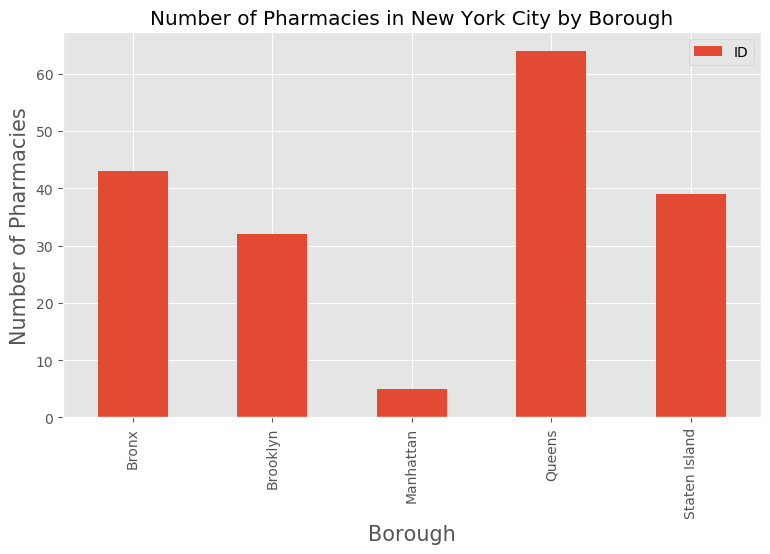

In [28]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Pharmacies in New York City by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Pharmacies', fontsize=15)
#giving a bar plot
pharmacy_ny_dd.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### Staten Island has the highest number of pharmacies while Queens is the second highest.

In [29]:
pharmacy_ny_dd.groupby('Neighborhood')['ID'].count().nlargest(17)

Neighborhood
Wakefield          6
New Springville    5
Starrett City      5
Great Kills        4
Mill Island        4
St. Albans         4
Todt Hill          4
Bellerose          3
Canarsie           3
Co-op City         3
Country Club       3
East Flatbush      3
Howard Beach       3
Hunts Point        3
Queens Village     3
Rockaway Beach     3
Tottenville        3
Name: ID, dtype: int64

The following code plots a bar graph of Pharmacies in each neighborhood of new york

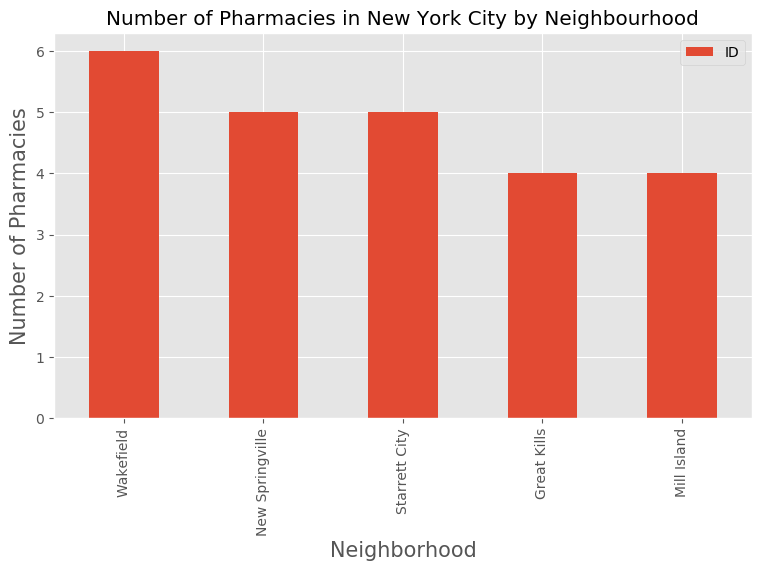

In [30]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Pharmacies in New York City by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Pharmacies', fontsize=15)
#giving a bar plot
pharmacy_ny_dd.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Wakefields in Bronx has the most Pharmacies with a total count of 6.

The follwoing lines of code will plot the top five neighborhoods and their pharmacies on a map.

In [31]:
io1=pharmacy_ny[pharmacy_ny['Neighborhood'] == 'Wakefield']
io2=pharmacy_ny[pharmacy_ny['Neighborhood']== 'New Springville']
io3=pharmacy_ny[pharmacy_ny['Neighborhood']== 'Starrett City']
io4=pharmacy_ny[pharmacy_ny['Neighborhood']== 'Todt Hill']
io5=pharmacy_ny[pharmacy_ny['Neighborhood']== 'Great Kills']

In [32]:
io=pd.concat([io1, io2,io3,io4,io5])

In [33]:
top_ny_neighborhood=pd.merge(io,new_york_data, on='Neighborhood')

In [34]:
# create map and display it
ny_map = folium.Map(location=(40.76158, -74.03478), zoom_start=11)

In [35]:
# instantiate a feature group for the incidents in the dataframe
Pharmacies = folium.map.FeatureGroup()

# loop through the 36 Pharmacies and add each to the incidents feature group
for lat, lng, in top_ny_neighborhood[['Latitude','Longitude']].values:
    Pharmacies.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [36]:
top_ny_neighborhood['Label']=top_ny_neighborhood['Neighborhood']+', '+top_ny_neighborhood['Borough_x']+'('+top_ny_neighborhood['Name'].map(str)+')'

In [37]:
FactoryData =pd.DataFrame({
    'Borough_x' : ['Queens'],
    'Neighborhood' : ['College Point'],
    'ID' : ['NaN'],
    'Name' : ['College Point'],
    'Borough_y' : ['Queens'],
    'Latitude' : [40.7809],
    'Longitude' : [-73.8578],
    'Label' : ['Ideal Fatory Location']
})

The following map of New York City shows the location of the top 5 neighborhoods which have higher number of pharmacies.

In [99]:
# add pop-up text to each marker on the map
for lat, lng, label in top_ny_neighborhood[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(Pharmacies)

The following data frame shows that the 5 neighborhoods contain 26 pharmacied all together. Which is e very small number campared to the total of 185 pharmacies.

In [39]:
top_ny_neighborhood

,Borough_x,Neighborhood,ID,Name,Borough_y,Latitude,Longitude,Label
0,Bronx,Wakefield,4beda0fc6e8c20a14aa97061,Rite Aid,Bronx,40.894705,-73.847201,"Wakefield, Bronx(Rite Aid)"
1,Bronx,Wakefield,4bb4deb4a70595218bd41bce,CVS pharmacy,Bronx,40.894705,-73.847201,"Wakefield, Bronx(CVS pharmacy)"
2,Bronx,Wakefield,4d6af9426107f04dedeb297a,Rite Aid,Bronx,40.894705,-73.847201,"Wakefield, Bronx(Rite Aid)"
3,Bronx,Wakefield,4bd6e0c529eb9c74c1b395e1,Walgreens,Bronx,40.894705,-73.847201,"Wakefield, Bronx(Walgreens)"
4,Bronx,Wakefield,4e3b2b9a1495bf24a5bcf1cb,Walgreens,Bronx,40.894705,-73.847201,"Wakefield, Bronx(Walgreens)"
5,Bronx,Wakefield,4ff489e3e4b08a4c7173f994,CVS pharmacy,Bronx,40.894705,-73.847201,"Wakefield, Bronx(CVS pharmacy)"
6,Staten Island,New Springville,4be5c380d4f7c9b620e32520,Rite Aid,Staten Island,40.594252,-74.164960,"New Springville, Staten Island(Rite Aid)"
7,Staten Island,New Springville,4be454f9477d9c74ef8de62d,CVS pharmacy,Staten Island,40.594252,-74.164960,"New Springville, Staten Island(CVS pharmacy)"
8,Staten Island,New Springville,4d7940b5109eb1f791be5c06,CVS pharmacy,Staten Island,40.594252,-74.164960,"New Springville, Staten Island(CVS pharmacy)"
9,Staten Island,New Springville,4b800621f964a520984b30e3,CVS pharmacy,Staten Island,40.594252,-74.164960,"New Springville, Staten Island(CVS pharmacy)"


In [40]:
pharmacy_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4beda0fc6e8c20a14aa97061,Rite Aid
1,Bronx,Wakefield,4bb4deb4a70595218bd41bce,CVS pharmacy
2,Bronx,Wakefield,4d6af9426107f04dedeb297a,Rite Aid
3,Bronx,Wakefield,4bd6e0c529eb9c74c1b395e1,Walgreens
4,Bronx,Wakefield,4e3b2b9a1495bf24a5bcf1cb,Walgreens


The following code extracts data about the pharmacies which can be used for determining customer support for the pharmacies. This is data such as likes, rating and tips. This data can give an idea of the pharmacies that are active and more likely to buy stock frequently.

In [49]:
# prepare neighborhood list that contains Pharmacies
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
pharmacy_stats_ny=pd.DataFrame(columns=column_names)
pharmacy_stats_ny1=pd.DataFrame(columns=column_names)
count=1


for row in pharmacy_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains pharmacies
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
pharmacy_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in pharmacy_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        #print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        #print('No data available for id=',ID)
        # we will assign 0 value for these pharmacies as they may have been 
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(pharmacy_ny),')','processed')
    pharmacy_stats_ny = pharmacy_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips,
                                               }, ignore_index=True)
    count+=1

Foursquare didnt return any data about pharmacies, therefore this data will be discarded but can be used for future additions to the study if obtained.

In [51]:
pharmacy_stats_ny.shape

(506, 7)

In [52]:
pharmacy_ny.shape

(505, 4)

In [53]:
pharmacy_stats_ny.to_csv('pharmacy_stats_ny.csv', index=False)

In [54]:
pharmacy_stats_ny_csv=pd.read_csv('pharmacy_stats_ny.csv')

In [55]:
pharmacy_stats_ny_csv.shape

(506, 7)

In [56]:
pharmacy_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4beda0fc6e8c20a14aa97061,Rite Aid,NaN,NaN,NaN
1,Bronx,Wakefield,4bb4deb4a70595218bd41bce,CVS pharmacy,NaN,NaN,NaN
2,Bronx,Wakefield,4d6af9426107f04dedeb297a,Rite Aid,NaN,NaN,NaN
3,Bronx,Wakefield,4bd6e0c529eb9c74c1b395e1,Walgreens,NaN,NaN,NaN
4,Bronx,Wakefield,4e3b2b9a1495bf24a5bcf1cb,Walgreens,NaN,NaN,NaN


In [57]:
pharmacy_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       506 non-null    object 
 1   Neighborhood  506 non-null    object 
 2   ID            506 non-null    object 
 3   Name          506 non-null    object 
 4   Likes         1 non-null      float64
 5   Rating        1 non-null      float64
 6   Tips          1 non-null      float64
dtypes: float64(3), object(4)
memory usage: 27.8+ KB


In [58]:
pharmacy_stats_ny['Likes']=pharmacy_stats_ny['Likes'].astype('float64')

In [59]:
pharmacy_stats_ny['Tips']=pharmacy_stats_ny['Tips'].astype('float64')

In [60]:
pharmacy_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       506 non-null    object 
 1   Neighborhood  506 non-null    object 
 2   ID            506 non-null    object 
 3   Name          506 non-null    object 
 4   Likes         1 non-null      float64
 5   Rating        1 non-null      float64
 6   Tips          1 non-null      float64
dtypes: float64(3), object(4)
memory usage: 27.8+ KB


In [61]:
# Pharmacies with maximum Likes
pharmacy_stats_ny.iloc[pharmacy_stats_ny['Likes'].idxmax()]

Borough         Staten Island
Neighborhood        Fox Hills
ID                          0
Name                        0
Likes                       0
Rating                      0
Tips                        0
Name: 505, dtype: object

In [62]:
# Pharmacies with maximum Tips
pharmacy_stats_ny.iloc[pharmacy_stats_ny['Tips'].idxmax()]

Borough         Staten Island
Neighborhood        Fox Hills
ID                          0
Name                        0
Likes                       0
Rating                      0
Tips                        0
Name: 505, dtype: object

In [63]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [64]:
pharmacy_ny.tail()

,Borough,Neighborhood,ID,Name
500,Queens,Bayswater,50058548e4b07c19de39effd,Vista Pharmacy & Surgical
501,Staten Island,Fox Hills,4b2ea393f964a5200ae424e3,CVS pharmacy
502,Staten Island,Fox Hills,4ce97b54595cb1f723e8ce14,Rite Aid
503,Staten Island,Fox Hills,4df38b0522718759f82017a1,Millers pharmacy
504,Staten Island,Fox Hills,4c4722f71ddec9289e639c32,"Classic Pharmacy, Inc."


In [65]:
all_pharmacies=pd.merge(pharmacy_ny,new_york_data, on='Neighborhood')

In [66]:
all_pharmacies.tail()

,Borough_x,Neighborhood,ID,Name,Borough_y,Latitude,Longitude
508,Queens,Bayswater,50058548e4b07c19de39effd,Vista Pharmacy & Surgical,Queens,40.611322,-73.765968
509,Staten Island,Fox Hills,4b2ea393f964a5200ae424e3,CVS pharmacy,Staten Island,40.617311,-74.081740
510,Staten Island,Fox Hills,4ce97b54595cb1f723e8ce14,Rite Aid,Staten Island,40.617311,-74.081740
511,Staten Island,Fox Hills,4df38b0522718759f82017a1,Millers pharmacy,Staten Island,40.617311,-74.081740
512,Staten Island,Fox Hills,4c4722f71ddec9289e639c32,"Classic Pharmacy, Inc.",Staten Island,40.617311,-74.081740


Assesing the all_pharmacies data frame above which is the data frame containing pharmacies, it can be seen that the coordinated are of the boroughs and not the pharmacy, therefore the following lines of code will pull coordinates of the pharmacies from foursquare and the data will be cleaned to obtain a data frame.

In [101]:
   #Vusi
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
   



In [68]:
#function to format url
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [69]:
url = format_url(all_pharmacies['Latitude'][0], all_pharmacies['Longitude'][0])

url

'https://api.foursquare.com/v2/venues/explore?client_id=DPBYY4JUY3DU20ALPSUV4ONY2K1GOJJKJ1NIHBB32XEMOVYY&client_secret=1MV443TYEP4HUO0WDUW5NQ5W10L2Y4G05NWG11WIR3NUGC5B&ll=40.89470517661,-73.84720052054902&v=20180604&radius=500&limit=100'

In [70]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [71]:
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

In [72]:
venues_df = get_venues(url)

venues_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.delivery.id,venue.delivery.url,venue.delivery.provider.name,venue.delivery.provider.icon.prefix,venue.delivery.provider.icon.sizes,venue.delivery.provider.icon.name
0,e-0-4c537892fd2ea593cb077a28-0,0,"[{'summary': 'This spot is popular', 'type': '...",4c537892fd2ea593cb077a28,Lollipops Gelato,4120 Baychester Ave,Edenwald & Bussing Ave,40.894123,-73.845892,"[{'label': 'display', 'lat': 40.89412315020527...",127,10466,US,Bronx,NY,United States,"[4120 Baychester Ave (Edenwald & Bussing Ave),...","[{'id': '4bf58dd8d48988d1d0941735', 'name': 'D...",0,[],NaN,NaN,NaN,NaN,NaN,NaN
1,e-0-4c783cef3badb1f7e4244b54-1,0,"[{'summary': 'This spot is popular', 'type': '...",4c783cef3badb1f7e4244b54,Carvel Ice Cream,1006 E 233rd St,NaN,40.890487,-73.848568,"[{'label': 'display', 'lat': 40.89048668575960...",483,10466,US,Bronx,NY,United States,"[1006 E 233rd St, Bronx, NY 10466, United States]","[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",0,[],NaN,NaN,NaN,NaN,NaN,NaN
2,e-0-5d5f5044d0ae1c0008f043c3-2,0,"[{'summary': 'This spot is popular', 'type': '...",5d5f5044d0ae1c0008f043c3,Walgreens,4232 Baychester Ave,Pitman,40.896528,-73.844700,"[{'label': 'display', 'lat': 40.896528, 'lng':...",292,10466,US,Bronx,NY,United States,"[4232 Baychester Ave (Pitman), Bronx, NY 10466...","[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],NaN,NaN,NaN,NaN,NaN,NaN
3,e-0-4d6af9426107f04dedeb297a-3,0,"[{'summary': 'This spot is popular', 'type': '...",4d6af9426107f04dedeb297a,Rite Aid,4232 Baychester Ave,NaN,40.896649,-73.844846,"[{'label': 'display', 'lat': 40.896649, 'lng':...",293,10466,US,Bronx,NY,United States,"[4232 Baychester Ave, Bronx, NY 10466, United ...","[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",0,[],NaN,NaN,NaN,NaN,NaN,NaN
4,e-0-4c25c212f1272d7f836385c5-4,0,"[{'summary': 'This spot is popular', 'type': '...",4c25c212f1272d7f836385c5,Dunkin',980 E 233rd St,Paulding Ave,40.890459,-73.849089,"[{'label': 'display', 'lat': 40.8904587811365,...",498,10466,US,Bronx,NY,United States,"[980 E 233rd St (Paulding Ave), Bronx, NY 1046...","[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",0,[],1984066,https://www.seamless.com/menu/dunkin-980-e-233...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png


In [73]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = ['venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'id': '4bf58dd8d48988d1d0941735', 'name': 'D...",40.894123,-73.845892,Lollipops Gelato
1,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",40.890487,-73.848568,Carvel Ice Cream
2,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",40.896528,-73.844700,Walgreens
3,"[{'id': '4bf58dd8d48988d10f951735', 'name': 'P...",40.896649,-73.844846,Rite Aid
4,"[{'id': '4bf58dd8d48988d148941735', 'name': 'D...",40.890459,-73.849089,Dunkin'


In [74]:
venues_df.loc[3, 'Category']

[{'id': '4bf58dd8d48988d10f951735',
  'name': 'Pharmacy',
  'pluralName': 'Pharmacies',
  'shortName': 'Pharmacy',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/pharmacy_',
   'suffix': '.png'},
  'primary': True}]

In [75]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Dessert Shop,40.894123,-73.845892,Lollipops Gelato
1,Ice Cream Shop,40.890487,-73.848568,Carvel Ice Cream
2,Pharmacy,40.896528,-73.844700,Walgreens
3,Pharmacy,40.896649,-73.844846,Rite Aid
4,Donut Shop,40.890459,-73.849089,Dunkin'
5,Gas Station,40.894187,-73.845862,Shell
6,Sandwich Place,40.890468,-73.849152,Subway
7,Pizza Place,40.898399,-73.848810,Louis Pizza
8,Laundromat,40.891281,-73.849904,Koss Quick Wash


In [76]:
#function to construct the dataframe with all the pharmacy's coordinates
def get_all_venues(ID, lat, lng):
    venues_list=[]
    for ID, lat, lng in zip(ID, lat, lng):
        url= format_url(lat, lng)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            ID, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Pharmacy ID', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Pharmacy', 
                  'Pharmacy Latitude', 
                  'Pharmacy Longitude',
                  'Pharmacy Category'
                  ]
    
    return all_venues

In [77]:
all_pharmacies.tail()

,Borough_x,Neighborhood,ID,Name,Borough_y,Latitude,Longitude
508,Queens,Bayswater,50058548e4b07c19de39effd,Vista Pharmacy & Surgical,Queens,40.611322,-73.765968
509,Staten Island,Fox Hills,4b2ea393f964a5200ae424e3,CVS pharmacy,Staten Island,40.617311,-74.081740
510,Staten Island,Fox Hills,4ce97b54595cb1f723e8ce14,Rite Aid,Staten Island,40.617311,-74.081740
511,Staten Island,Fox Hills,4df38b0522718759f82017a1,Millers pharmacy,Staten Island,40.617311,-74.081740
512,Staten Island,Fox Hills,4c4722f71ddec9289e639c32,"Classic Pharmacy, Inc.",Staten Island,40.617311,-74.081740


In [106]:
all_venues = get_all_venues(all_pharmacies['ID'],all_pharmacies['Latitude'], all_pharmacies['Longitude'])

print('The total number of venues returned is ', all_venues.shape[0])

all_venues.head(10)

The total number of venues returned is  9370


,Pharmacy ID,Borough Latitude,Borough Longitude,Pharmacy,Pharmacy Latitude,Pharmacy Longitude,Pharmacy Category
0,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
5,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
6,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
7,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat
8,4bb4deb4a70595218bd41bce,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
9,4bb4deb4a70595218bd41bce,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop


It can be seen that the all_venues data frame returned all venues in new york city. These venues will be cleaned by only filtering for pharmacies.

In [107]:
all_venues.to_csv('all_venues.csv', index=False)

In [78]:
all_venues=pd.read_csv('all_venues.csv')

In [79]:
All_PharmaciesNY=all_venues[all_venues['Pharmacy Category'] == 'Pharmacy']

In [80]:
All_PharmaciesNY.head()

,Pharmacy ID,Borough Latitude,Borough Longitude,Pharmacy,Pharmacy Latitude,Pharmacy Longitude,Pharmacy Category
2,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,4beda0fc6e8c20a14aa97061,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
10,4bb4deb4a70595218bd41bce,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
11,4bb4deb4a70595218bd41bce,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
18,4d6af9426107f04dedeb297a,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy


In [81]:
ALL_PHARMACIES=All_PharmaciesNY.drop_duplicates(subset=['Pharmacy ID'])

In [82]:
ALL_PHARMACIES.shape

(134, 7)

Looking at the results of pulling pharmacies coordinatesit can be seen that their corrdinated are unique and the duplicates are romoved further which reduces the number from 185 to 134. It should be noted that this data might not be that accurate due to foursquare data inconsistencies.

# Clustering 

The following lines of codes performs a K-means clustering on the above 134 pharmacies to determine the centroid that can be used as the pharmaceutical factory.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

Defining the data to be clustered. The coordinates of the pharmacies are changed to X which is an array for the ease of writing the code and best interpretation on cartesian plane.

In [86]:
Xs1=ALL_PHARMACIES.iloc[:,4:6]
Xs=Xs1[['Pharmacy Longitude','Pharmacy Latitude']]
X=np.array(Xs)

In [87]:
Xs.head()

,Pharmacy Longitude,Pharmacy Latitude
2,-73.8447,40.896528
10,-73.8447,40.896528
18,-73.8447,40.896528
26,-73.8447,40.896528
34,-73.8447,40.896528


A scatter plot of the data is drawn to visualize the distribution of the pharmacies

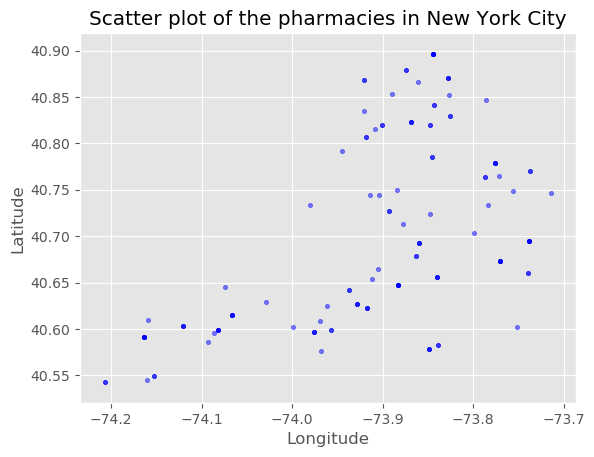

In [88]:
import numpy as np
import matplotlib.pyplot as plt

x = Xs.iloc[:,0]
y = Xs.iloc[:,1]
area = np.pi*3

# Plot
plt.scatter(x, y, s=area, c='b', alpha=0.5)
plt.title('Scatter plot of the pharmacies in New York City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [89]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

#print(centroids)
#print(labels)

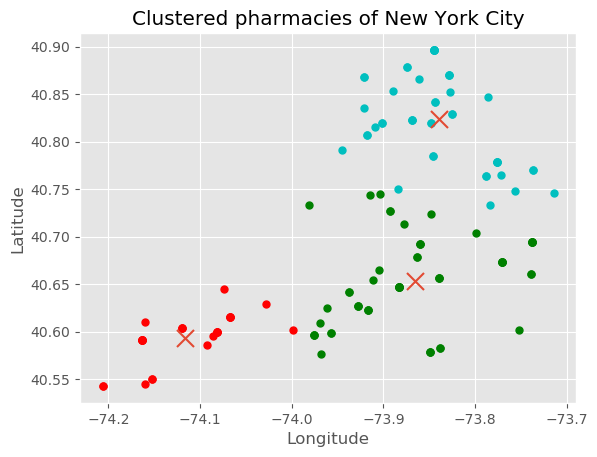

In [90]:
colors = ["g.","r.","c.","y."]

for i in range(len(X)):
    #print("coordinate:",X[i], "label:", labels[i])
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 10)


plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=150, linewidths = 5, zorder = 10)
plt.title('Clustered pharmacies of New York City')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [91]:
centroids

array([[-73.86543917,  40.65372257],
       [-74.1162373 ,  40.59343698],
       [-73.83983081,  40.82388884]])

### The locations found from the results of clustering above are as follows:\
Factory location 1 (Blue) = Seaview Ave, Brooklyn\
Factory location 2 (Red) = Wetchester Ave, Bronx\
Factory location 3 (Green) = Yellow trail, Staten Island

The following lines of code are used to draw a map with a pop up of these three locations.

In [106]:
FactoryData =pd.DataFrame({
    'Pharmacy ID' : ['Yellow Trail: Staten Island','Wetchester Ave: Bronx','Seaview Ave: Brooklyn'],
    'Borough Latitude' : [40.59343698,40.82388884,40.65372257],
    'Borough Longitude' : [-74.1162373,-73.83983081,-73.86543917],
    'Pharmacy' : ['Factory',' Factory','Factory'],
    'Pharmacy Latitude' : [40.59343698,40.82388884,40.65372257],
    'Pharmacy Longitude' : [-74.1162373,-73.83983081,-73.86543917],
    'Pharmacy Category' : ['Fatory Location','Factory Location','Factory Location']
})

In [107]:
FactoryData = FactoryData.rename(columns={'Pharmacy ID': 'PharmacyID'})
FactoryData

,PharmacyID,Borough Latitude,Borough Longitude,Pharmacy,Pharmacy Latitude,Pharmacy Longitude,Pharmacy Category
0,Yellow Trail: Staten Island,40.593437,-74.116237,Factory,40.593437,-74.116237,Fatory Location
1,Wetchester Ave: Bronx,40.823889,-73.839831,Factory,40.823889,-73.839831,Factory Location
2,Seaview Ave: Brooklyn,40.653723,-73.865439,Factory,40.653723,-73.865439,Factory Location


In [108]:
ALL_PHARMACIES_AND_FACTORY=ALL_PHARMACIES.append(FactoryData)

In [109]:
ALL_PHARMACIES_AND_FACTORY.tail()


,Pharmacy ID,Borough Latitude,Borough Longitude,Pharmacy,Pharmacy Latitude,Pharmacy Longitude,Pharmacy Category,PharmacyID
9120,4bb7d4213db7b713c7a1209a,40.716415,-73.881143,AJ's Village Chemist,40.712905,-73.878023,Pharmacy,NaN
9236,4c55c2d9479fc928503f6995,40.865788,-73.859319,Rite Aid,40.865949,-73.860922,Pharmacy,NaN
0,NaN,40.593437,-74.116237,Factory,40.593437,-74.116237,Fatory Location,Yellow Trail: Staten Island
1,NaN,40.823889,-73.839831,Factory,40.823889,-73.839831,Factory Location,Wetchester Ave: Bronx
2,NaN,40.653723,-73.865439,Factory,40.653723,-73.865439,Factory Location,Seaview Ave: Brooklyn


In [110]:
# create map and display it
ny_map2 = folium.Map(location=(40.7736, -73.8295), zoom_start=10.4)

In [111]:
# instantiate a feature group for the incidents in the dataframe
Pharmacies2 = folium.map.FeatureGroup()

# loop through the 36 Pharmacies and add each to the incidents feature group
for lat, lng, in ALL_PHARMACIES[['Pharmacy Latitude','Pharmacy Longitude']].values:
    Pharmacies2.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.1
        )
    )

In [112]:
# adding pop-up text to each marker on the map
for lat, lng, PharmacyID in FactoryData[['Pharmacy Latitude','Pharmacy Longitude','PharmacyID']].values:
    folium.Marker([lat, lng], popup=PharmacyID).add_to(ny_map2)        
# add incidents to map
ny_map2.add_child(Pharmacies2)

## The locations Plotted on the Map Were Obtained from K-means Clustering Algorithm
Factory location 1 (Blue) = Seaview Ave, Brooklyn\
Factory location 2 (Red) = Wetchester Ave, Bronx\
Factory location 3 (Green) = Yellow trail, Staten Island

# The results of this clustering method are compared with all of the exploratory analysis to choose the best location to build a pharmaceutical factory, the second and third best locations are also given with business motivation. See the discussion and conclusion in the report section attached to this repository.

# --------------------------------------------------------Thank You!----------------------------------------